Dimensiones: (7043, 21)

Columnas: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

Tipos:
 customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Churn Rate: 26.54%


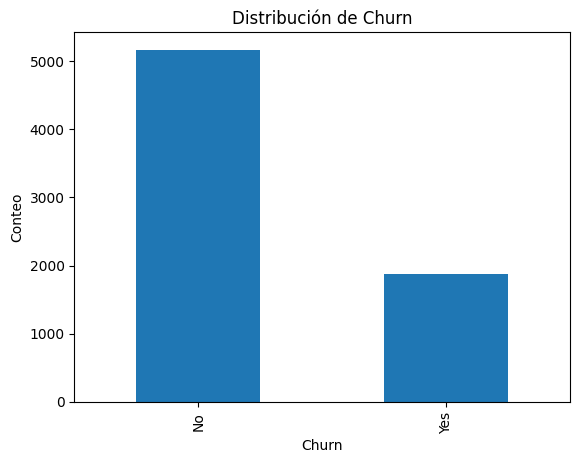

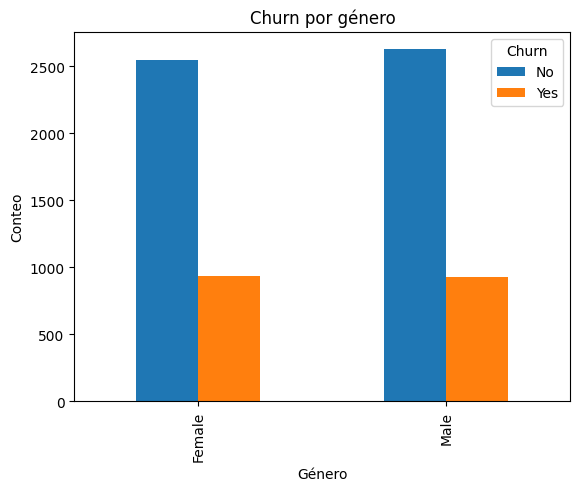

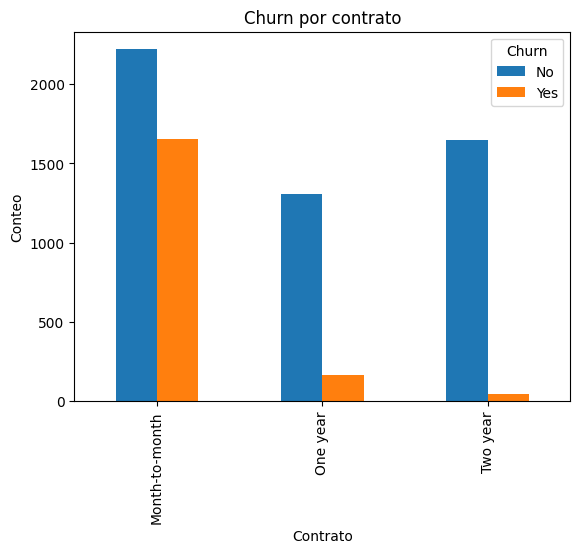

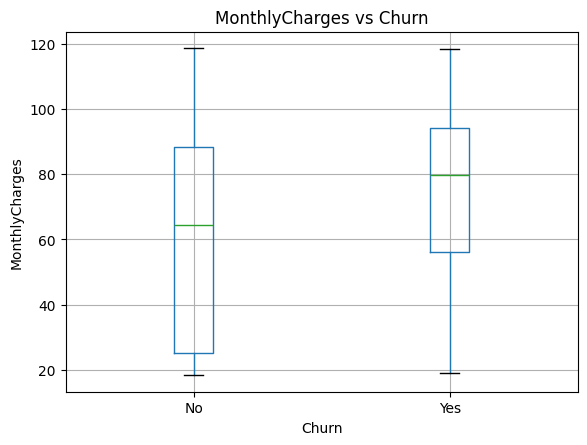


=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.91      0.74      0.82      1294
           1       0.53      0.78      0.63       467

    accuracy                           0.76      1761
   macro avg       0.72      0.76      0.72      1761
weighted avg       0.80      0.76      0.77      1761

ROC-AUC: 0.8376049564949744

=== Random Forest ===
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1294
           1       0.66      0.48      0.56       467

    accuracy                           0.80      1761
   macro avg       0.75      0.70      0.71      1761
weighted avg       0.79      0.80      0.79      1761

ROC-AUC: 0.8242456536344651

Conclusiones:
- El churn promedio es de 26.54%.
- Los contratos mensuales son los que más se cancelan.
- Cargos altos también se relacionan con mayor churn.


In [2]:
# 1) Primero importo las librerías que voy a usar (pandas, numpy, matplotlib, sklearn, etc.)
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

# 2) Cargo el dataset de churn
telco = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
print("Dimensiones:", telco.shape)
print("\nColumnas:", list(telco.columns))
print("\nTipos:\n", telco.dtypes)

# 3) Limpieza: convierto TotalCharges a numérico y los nulos los pongo en 0
telco["TotalCharges"] = pd.to_numeric(telco["TotalCharges"], errors="coerce").fillna(0)

# Creo una columna binaria para churn (1 si es Yes, 0 si es No)
telco["ChurnFlag"] = (telco["Churn"] == "Yes").astype(int)

# 4) Calculo el churn rate (promedio de ChurnFlag)
rate = 100 * telco["ChurnFlag"].mean()
print(f"\nChurn Rate: {rate:.2f}%")

# Gráfica de distribución del churn
telco["Churn"].value_counts().plot(kind="bar")
plt.title("Distribución de Churn")
plt.xlabel("Churn"); plt.ylabel("Conteo")
plt.show()

# Gráfica para ver churn por género
pd.crosstab(telco["gender"], telco["Churn"]).plot(kind="bar")
plt.title("Churn por género")
plt.xlabel("Género"); plt.ylabel("Conteo")
plt.show()

# Gráfica para ver churn según el tipo de contrato
pd.crosstab(telco["Contract"], telco["Churn"]).plot(kind="bar")
plt.title("Churn por contrato")
plt.xlabel("Contrato"); plt.ylabel("Conteo")
plt.show()

# Boxplot de MonthlyCharges y churn para ver relación
telco.boxplot(column="MonthlyCharges", by="Churn")
plt.title("MonthlyCharges vs Churn")
plt.suptitle("")
plt.xlabel("Churn"); plt.ylabel("MonthlyCharges")
plt.show()

# 5) Preparo los datos: elimino columnas que no voy a usar
X_raw = telco.drop(columns=["customerID", "Churn", "ChurnFlag"])
y = telco["ChurnFlag"]

# Identifico qué columnas son categóricas y cuáles son numéricas
cat_cols = X_raw.select_dtypes(include=["object"]).columns.tolist()
num_cols = X_raw.select_dtypes(include=[np.number]).columns.tolist()

# 6) Hago un preprocesador: escalado para numéricas y one-hot para categóricas
preproc = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), cat_cols),
    ]
)

# 7) Divido en train y test (75% y 25%) con estratificación
X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y, test_size=0.25, random_state=123, stratify=y
)

# 8) Entreno los modelos

# Logistic Regression
pipe_lr = Pipeline(steps=[
    ("prep", preproc),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
])
pipe_lr.fit(X_train, y_train)
pred_lr = pipe_lr.predict(X_test)
proba_lr = pipe_lr.predict_proba(X_test)[:, 1]

print("\n=== Logistic Regression ===")
print(classification_report(y_test, pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, proba_lr))

# Random Forest
pipe_rf = Pipeline(steps=[
    ("prep", preproc),
    ("clf", RandomForestClassifier(n_estimators=300, random_state=123, class_weight="balanced_subsample"))
])
pipe_rf.fit(X_train, y_train)
pred_rf = pipe_rf.predict(X_test)
proba_rf = pipe_rf.predict_proba(X_test)[:, 1]

print("\n=== Random Forest ===")
print(classification_report(y_test, pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, proba_rf))

# 9) Conclusiones rápidas (como observaciones finales)
print("\nConclusiones:")
print(f"- El churn promedio es de {rate:.2f}%.")
print("- Los contratos mensuales son los que más se cancelan.")
print("- Cargos altos también se relacionan con mayor churn.")

